In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Grokking on Prime Number Classification

This notebook trains a small 1-layer transformer to classify whether an integer $n \le N_{\max}$ is prime.  

The setup mirrors *Progress Measures for Grokking via Mechanistic Interpretability* (Nanda et al.):

- Finite, fully enumerable task (all integers in a range)
- Small training fraction (e.g. 30% of the domain)
- Overparameterized 1-layer transformer
- Full-batch AdamW with strong weight decay
- Long training (tens of thousands of epochs)

We log train/test accuracy and loss to look for grokking:  
high train accuracy achieved early, test accuracy stays near chance for many epochs, then abruptly jumps to high generalization.


In [2]:
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reproducibility
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)


Torch version: 2.6.0+cu124
Using device: cpu


In [3]:
def sieve_primes(n_max: int):
    """Return boolean mask is_prime[0..n_max]."""
    is_prime = np.ones(n_max + 1, dtype=bool)
    is_prime[:2] = False  # 0,1 not prime
    for p in range(2, int(math.sqrt(n_max)) + 1):
        if is_prime[p]:
            is_prime[p*p:n_max+1:p] = False
    return is_prime

# ======= configure problem =======
N_MAX = 401          # try other numbers 
TRAIN_FRACTION = 0.3 # fraction of numbers used for training. this number mimics Nanda paper.

# Generate labels
is_prime_mask = sieve_primes(N_MAX)
numbers = np.arange(2, N_MAX + 1) # domain: [2, N_MAX]
labels = is_prime_mask[2:] # same length as numbers

print(f"Total numbers: {len(numbers)}")
print(f"Primes in domain: {labels.sum()} ({labels.mean()*100:.1f}% of numbers)")

# ======= train / test split =======
num_total = len(numbers)
num_train = int(TRAIN_FRACTION * num_total)

indices = np.arange(num_total)
np.random.shuffle(indices)

train_idx = indices[:num_train]
test_idx  = indices[num_train:]

train_numbers = numbers[train_idx]
test_numbers  = numbers[test_idx]

train_labels = labels[train_idx].astype(np.int64)  # 0/1
test_labels  = labels[test_idx].astype(np.int64)

print(f"Train set size: {len(train_numbers)}")
print(f"Test set size:  {len(test_numbers)}")
print(f"Train prime fraction: {train_labels.mean():.3f}")
print(f"Test prime fraction:  {test_labels.mean():.3f}")


Total numbers: 400
Primes in domain: 79 (19.8% of numbers)
Train set size: 120
Test set size:  280
Train prime fraction: 0.200
Test prime fraction:  0.196


In [4]:
# Vocabulary:
# 0          : unused
# 1..N_MAX   : number tokens
# N_MAX + 1  : '=' token

EQ_TOKEN_ID = N_MAX + 1
VOCAB_SIZE = N_MAX + 2  # [0..N_MAX+1]

def make_inputs(nums: np.ndarray) -> torch.Tensor:
    """
    nums: array of shape (batch,) with integers in [2, N_MAX].
    Returns tensor of shape (batch, 2) with token IDs [n_token, eq_token].
    """
    # map n in [2, N_MAX] -> token id = n (we just reuse the integer itself)
    n_tokens = torch.from_numpy(nums.astype(np.int64))
    eq_tokens = torch.full_like(n_tokens, EQ_TOKEN_ID)
    x = torch.stack([n_tokens, eq_tokens], dim=1)  # (batch, 2)
    return x

train_inputs = make_inputs(train_numbers).to(device)
test_inputs  = make_inputs(test_numbers).to(device)

train_labels_t = torch.from_numpy(train_labels).to(device)
test_labels_t  = torch.from_numpy(test_labels).to(device)

print("train_inputs shape:", train_inputs.shape)
print("test_inputs shape:", test_inputs.shape)


train_inputs shape: torch.Size([120, 2])
test_inputs shape: torch.Size([280, 2])


In [5]:
class PrimeTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_mlp=512, seq_len=2):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(seq_len, d_model)  # positions 0, 1

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_mlp,
            batch_first=True,
            activation="relu",
            norm_first=False  # closer to the setup with no pre-LN
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.mlp_head = nn.Sequential(
            nn.Linear(d_model, d_mlp),
            nn.ReLU(),
            nn.Linear(d_mlp, 2)  # binary classification: composite vs prime
        )

    def forward(self, x):
        """
        x: (batch, seq_len) token IDs
        Returns: logits (batch, 2)
        """
        bsz, seq_len = x.shape
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(bsz, -1)

        h = self.token_embed(x) + self.pos_embed(pos)     # (batch, seq_len, d_model)
        h = self.encoder(h)                               # (batch, seq_len, d_model)

        # Use representation at '=' token (position 1) as in Nanda et al.
        eq_repr = h[:, 1, :]                              # (batch, d_model)
        logits = self.mlp_head(eq_repr)                   # (batch, 2)
        return logits

    def get_hidden_repr(self, x):
        """
        Returns the '=' position representation, for probes / analysis.
        """
        bsz, seq_len = x.shape
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(bsz, -1)

        h = self.token_embed(x) + self.pos_embed(pos)
        h = self.encoder(h)
        eq_repr = h[:, 1, :]
        return eq_repr


In [6]:
def accuracy(logits: torch.Tensor, labels: torch.Tensor) -> float:
    preds = logits.argmax(dim=-1)
    return (preds == labels).float().mean().item()

def weight_norm(model: nn.Module) -> float:
    total = 0.0
    for p in model.parameters():
        total += p.norm(2).item() ** 2
    return math.sqrt(total)

def class_weights(labels: torch.Tensor) -> torch.Tensor:
    """
    Simple inverse-frequency class weights for imbalanced binary labels (0/1).
    Returns tensor of shape (2,) for CE loss.
    """
    labels = labels.detach().cpu().numpy()
    counts = np.bincount(labels, minlength=2)
    freqs = counts / counts.sum()
    # Avoid divide-by-zero
    inv_freqs = 1.0 / np.maximum(freqs, 1e-6)
    w = inv_freqs / inv_freqs.mean()
    return torch.tensor(w, dtype=torch.float32)


Training loop. Main experiment is in this cell.

In [7]:
# ====== hyperparameters ======
d_model = 128
n_heads = 4
d_mlp = 512
num_epochs = 50000          # try 30000+ later for serious runs
log_every = 250

lr = 1e-3
weight_decay = 1.0          # strong weight decay, key for grokking

model = PrimeTransformer(VOCAB_SIZE, d_model=d_model, n_heads=n_heads, d_mlp=d_mlp).to(device)
print(model)

# Class weights for imbalance
cw = class_weights(train_labels_t).to(device)
criterion = nn.CrossEntropyLoss(weight=cw)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# ====== storage for logs ======
history = {
    "epoch": [],
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "weight_norm": [],
}

# Full-batch tensors
train_x = train_inputs
train_y = train_labels_t
test_x  = test_inputs
test_y  = test_labels_t

print("Starting training...")

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    logits = model(train_x)
    loss = criterion(logits, train_y)
    loss.backward()
    optimizer.step()

    if epoch % log_every == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            train_logits = model(train_x)
            test_logits  = model(test_x)

            train_loss = criterion(train_logits, train_y).item()
            test_loss  = criterion(test_logits, test_y).item()
            train_acc  = accuracy(train_logits, train_y)
            test_acc   = accuracy(test_logits, test_y)
            w_norm     = weight_norm(model)

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        history["weight_norm"].append(w_norm)

        print(
            f"Epoch {epoch:6d} | "
            f"train_loss={train_loss:.4f}, test_loss={test_loss:.4f}, "
            f"train_acc={train_acc:.3f}, test_acc={test_acc:.3f}, "
            f"||w||={w_norm:.3f}"
        )

print("Done.")


PrimeTransformer(
  (token_embed): Embedding(403, 128)
  (pos_embed): Embedding(2, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
Starting training...
Epoch      1 | train_l

Note from above: at 30,000 epochs, the prime number test did not achieve grokking. Now going to try with 50,000 epochs. oops, also didnt work with 50000 epochs.

Plotting learning curves

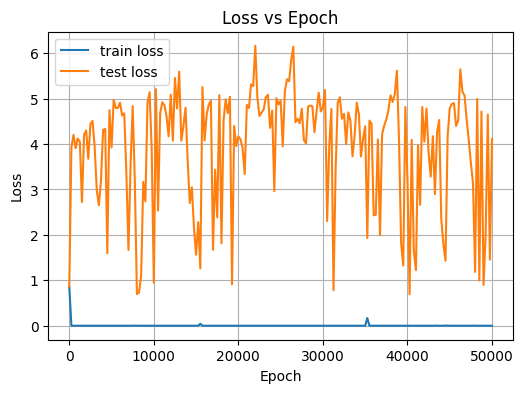

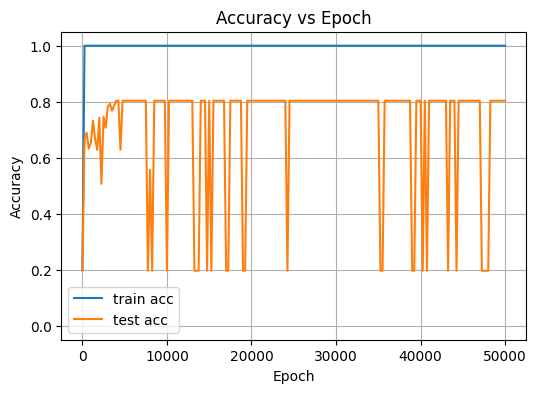

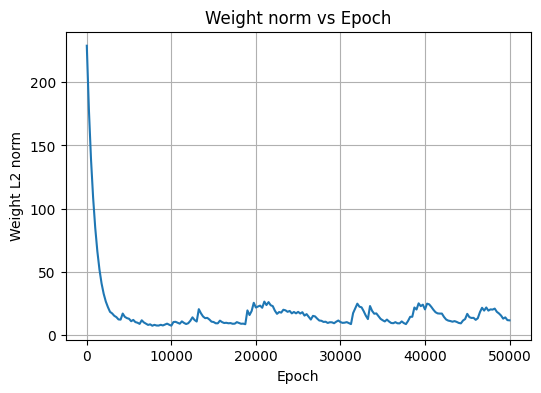

In [8]:
epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
test_loss = np.array(history["test_loss"])
train_acc = np.array(history["train_acc"])
test_acc = np.array(history["test_acc"])
w_norm = np.array(history["weight_norm"])

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, test_loss, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, label="train acc")
plt.plot(epochs, test_acc, label="test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, w_norm)
plt.xlabel("Epoch")
plt.ylabel("Weight L2 norm")
plt.title("Weight norm vs Epoch")
plt.grid(True)
plt.show()


Hidden representation dump for probes

In [9]:
model.eval()
with torch.no_grad():
    # Evaluate on the full domain [2..N_MAX] so we can probe the entire function
    all_numbers = np.arange(2, N_MAX + 1)
    all_inputs = make_inputs(all_numbers).to(device)
    all_labels = sieve_primes(N_MAX)[2:].astype(np.int64)

    all_repr = model.get_hidden_repr(all_inputs).cpu()  # (N_total, d_model)

print("all_repr shape:", all_repr.shape)


all_repr shape: torch.Size([400, 128])


# Now trying with balancing the train set!

In [10]:
N_MAX = 401  # or 601
all_numbers = np.arange(2, N_MAX+1)
all_labels = is_prime_mask[2:].astype(np.int64)

primes = all_numbers[all_labels == 1]
composites = all_numbers[all_labels == 0]

# choose train_primes and train_composites to balance train set
TRAIN_FRACTION = 0.3
num_total = len(all_numbers)
num_train = int(TRAIN_FRACTION * num_total)

# Make train set ~balanced
num_train_each = num_train // 2
train_primes = np.random.choice(primes, size=min(num_train_each, len(primes)), replace=False)
train_composites = np.random.choice(composites, size=num_train - len(train_primes), replace=False)

train_numbers = np.concatenate([train_primes, train_composites])
np.random.shuffle(train_numbers)

# test set = everything else
mask = np.isin(all_numbers, train_numbers, invert=True)
test_numbers = all_numbers[mask]
